In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

## Functions

In [2]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [3]:
def predict_evaluate(prediction, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        resultingPlot = plt.figure(figsize=(25,10))
        plt.plot(true, color='red', label='Original Usage')
        plt.plot(prediction, color='blue', label='Predicted Usage')
        #plt.plot(diff, color='green', label='Error')
        plt.title(graphName)
        plt.ylabel('kW')
        plt.legend()
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    #return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}
    return mae

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=8,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    #loss_per_epoch = history.history['loss']
    
    #if showplot:
    #    plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [5]:
featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24


## GENERIC MODEL

In [6]:
directory = "../../datsets/LCL_Data_Transformed/train"
trainHouses = sorted(os.listdir(directory))

In [7]:
generic_Model = load_model("generic_Model/Generic_Model.sav")
x_scaler = load_model("generic_Model/x_scaler.sav")
y_scaler = load_model("generic_Model/y_scaler.sav")

SCALER

In [ ]:
#SCALERS
x_scaler = StandardScaler()
y_scaler = StandardScaler()

d = {key:[] for key in featuresNames}
allDF = pd.DataFrame(data=d)

for filename in trainHouses:
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        allDF = pd.concat([allDF, df[featuresNames]], ignore_index=True)

        
allFeatures = allDF[featuresNames].values
allTargets = allDF[targetName].values
        
x_scaler.fit(allFeatures)
y_scaler.fit(allTargets)

save_model(x_scaler, "generic_Model/x_scaler.sav")
save_model(y_scaler, "generic_Model/y_scaler.sav")



GENERIC MODEL

In [ ]:
#generic_Model = define_model(past_window, len(featuresNames))

#Retreived already trained houses
fileTrain = open('generic_Model/trainedHouses.txt', 'r')
trainedHouses = fileTrain.read().splitlines()
fileTrain.close()

for filename in trainHouses:
    
    #already trained
    if filename in trainedHouses:
        continue
    
    print("Training with ", filename)
    
    #Read file
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_train = x_scaler.transform(features)
        y_train = y_scaler.transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(generic_Model, train_generator)
        
        #Save model and update trained houses
        save_model(generic_Model, "generic_Model/Generic_Model.sav")
        fileTrain = open('generic_Model/trainedHouses.txt', 'a')
        fileTrain.write(filename + "\n")
        fileTrain.close() 



## Case Study

In [15]:
directory = "../../datsets/LCL_Data_Transformed/test"
testHouses = sorted(os.listdir(directory))

testHouses = sample(testHouses, 2)

Testing with  MAC000032.csv
------------------GENERIC MODEL------------------


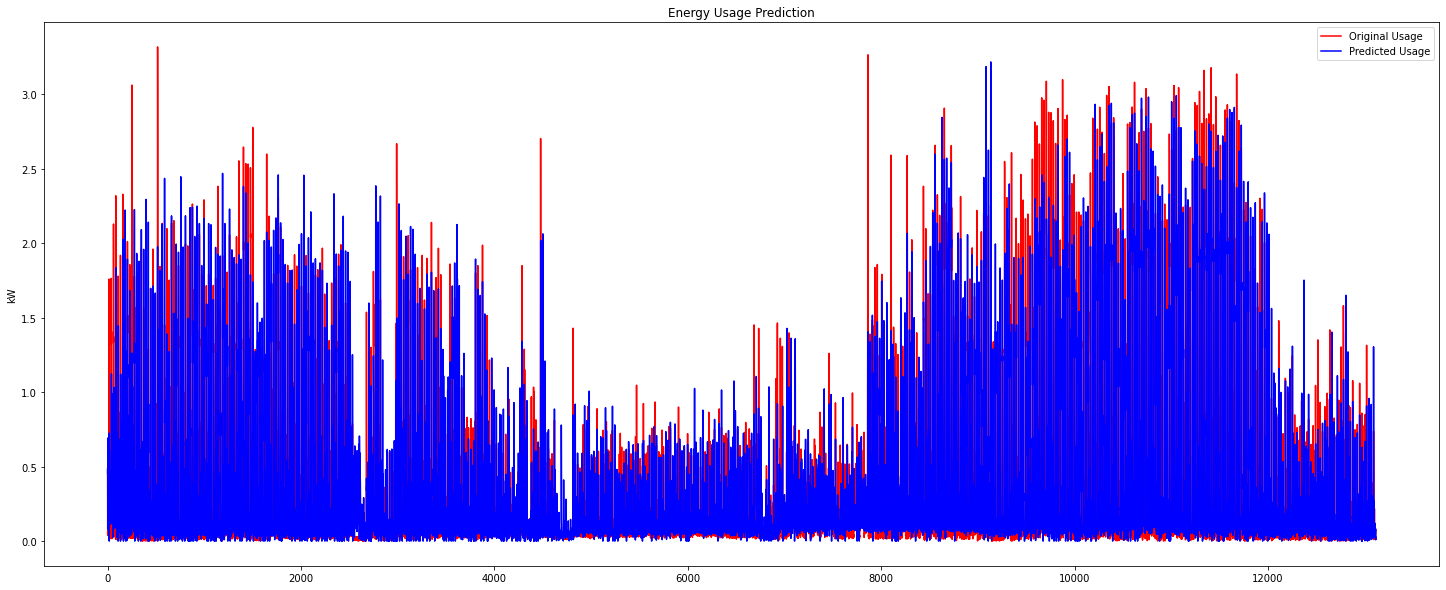

Mean Absolute Percentage Error:  2.009219528346012
Mean Absolute Error:  0.13053123835792066
Max Absolute Error:  2.9885
Mean Squared Error:  0.06121362795335696
---After 1 year---


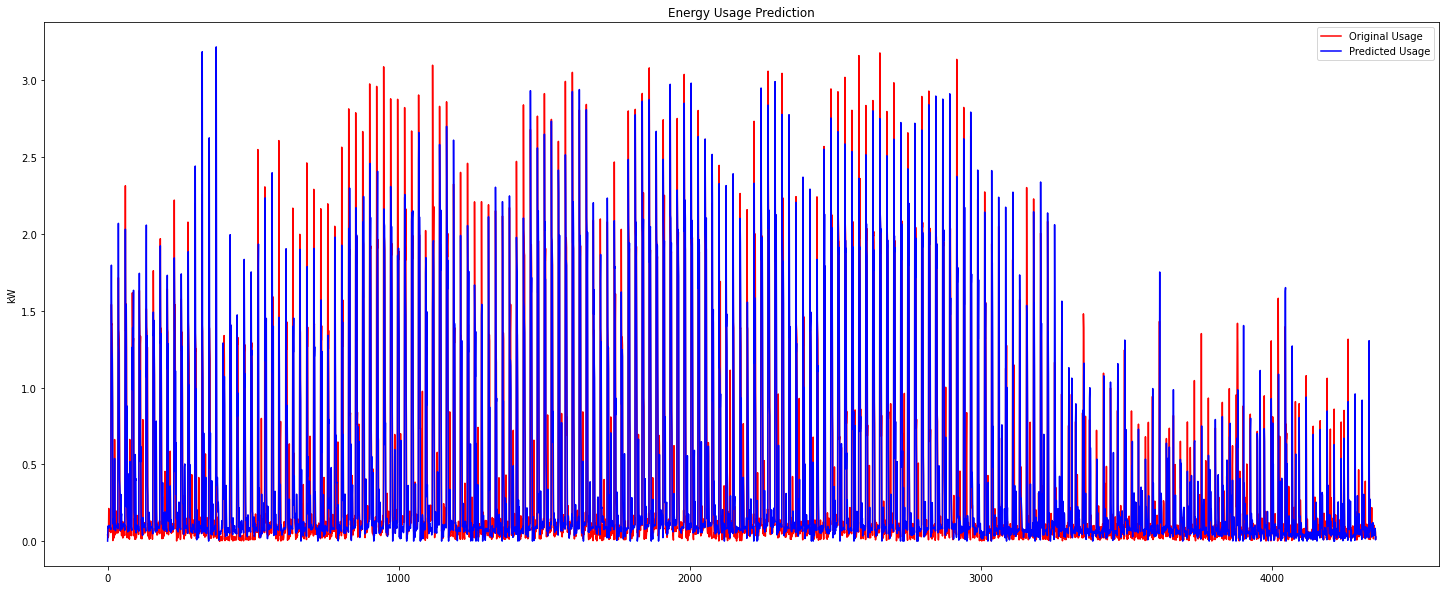

Mean Absolute Percentage Error:  2.0280710873465484
Mean Absolute Error:  0.12782795718723713
Max Absolute Error:  [2.6856859]
Mean Squared Error:  0.0612997221679612
------------------SPECIFIC MODEL------------------


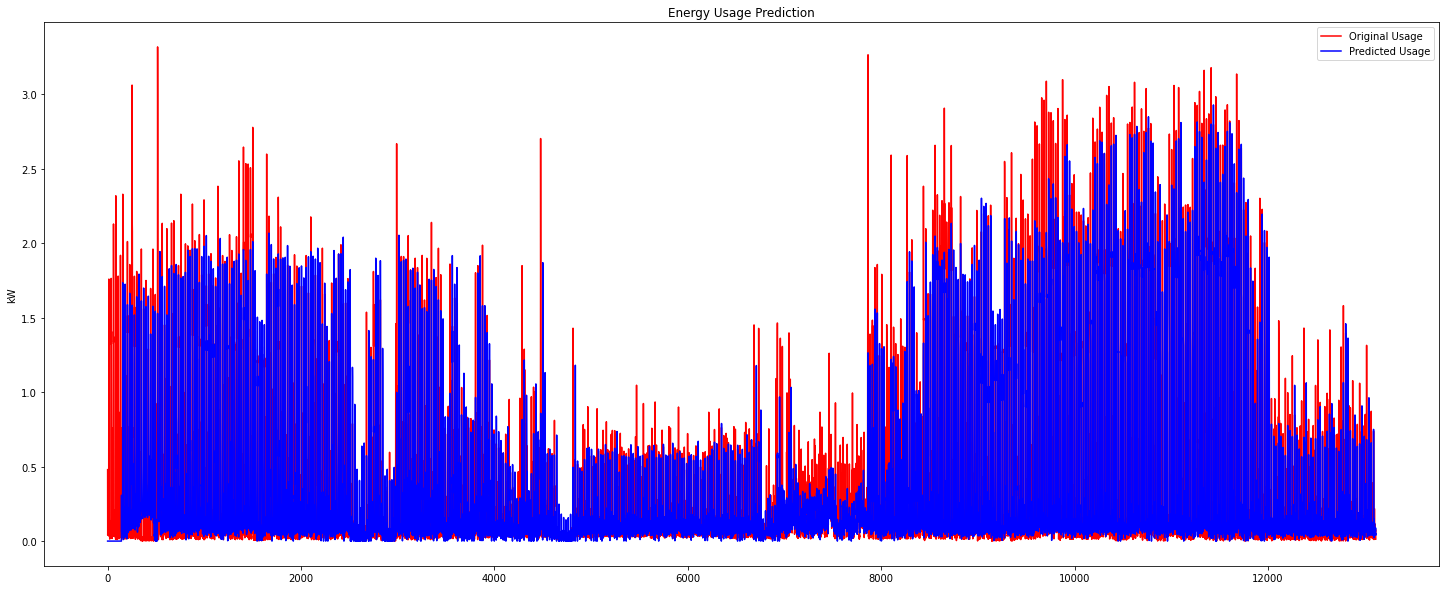

Mean Absolute Percentage Error:  1.756103952417788
Mean Absolute Error:  0.11094478117980609
Max Absolute Error:  2.3195
Mean Squared Error:  0.04838865176851102
---After 1 year---


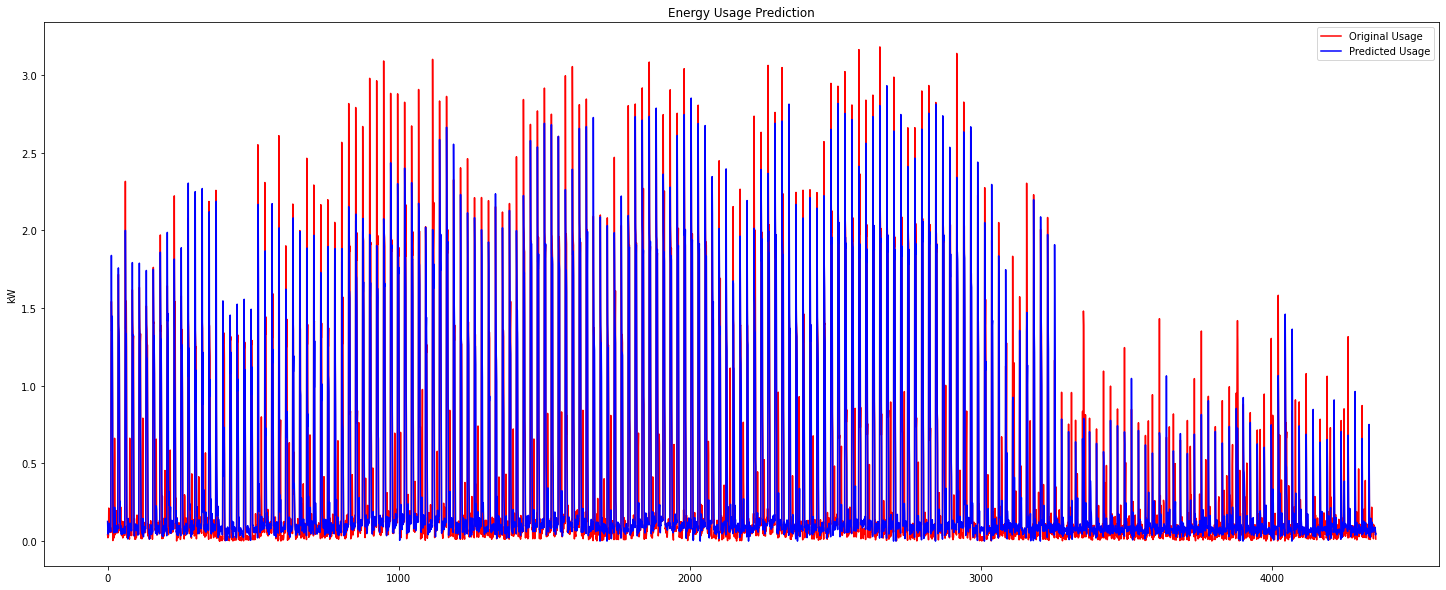

Mean Absolute Percentage Error:  1.8557923222387587
Mean Absolute Error:  0.10400192132036047
Max Absolute Error:  1.5206532595832845
Mean Squared Error:  0.036477900989014114
------------------BEST MODEL------------------


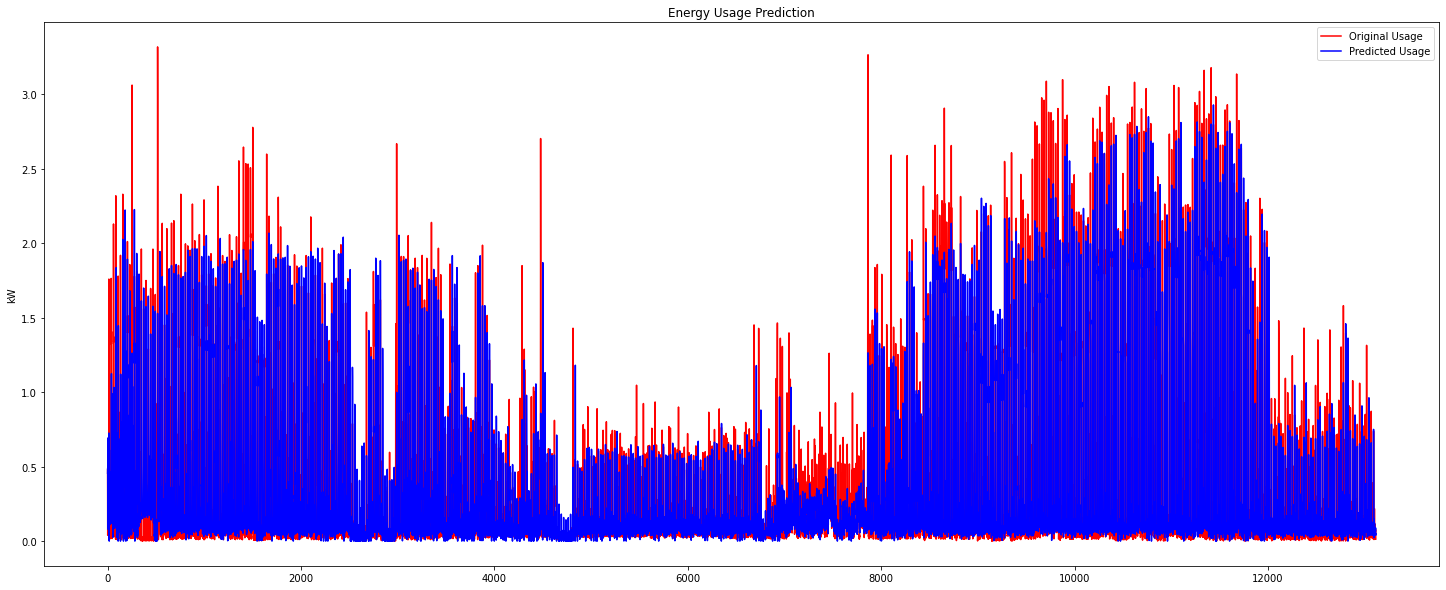

Mean Absolute Percentage Error:  1.7784625456711989
Mean Absolute Error:  0.11061386552210396
Max Absolute Error:  2.0446573326109565
Mean Squared Error:  0.04633039366373639
Testing with  MAC000498.csv
------------------GENERIC MODEL------------------


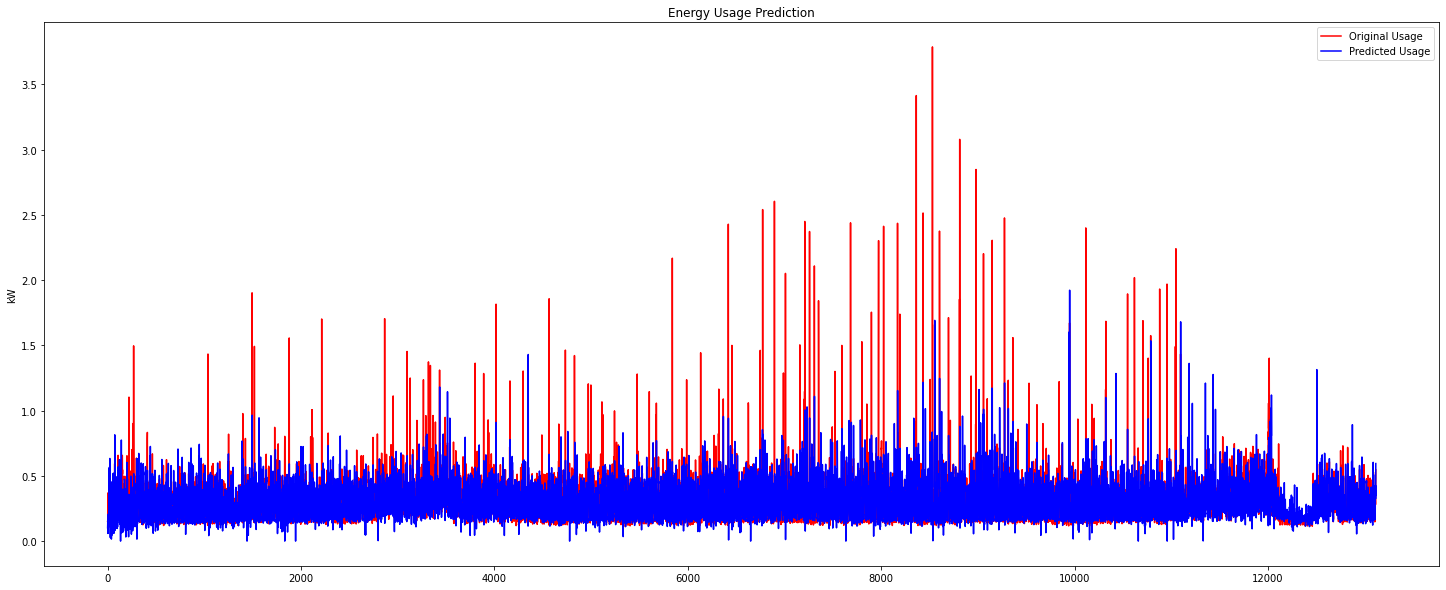

Mean Absolute Percentage Error:  0.28125121719255397
Mean Absolute Error:  0.0864788923302286
Max Absolute Error:  [3.0563307]
Mean Squared Error:  0.029190014481450685
---After 1 year---


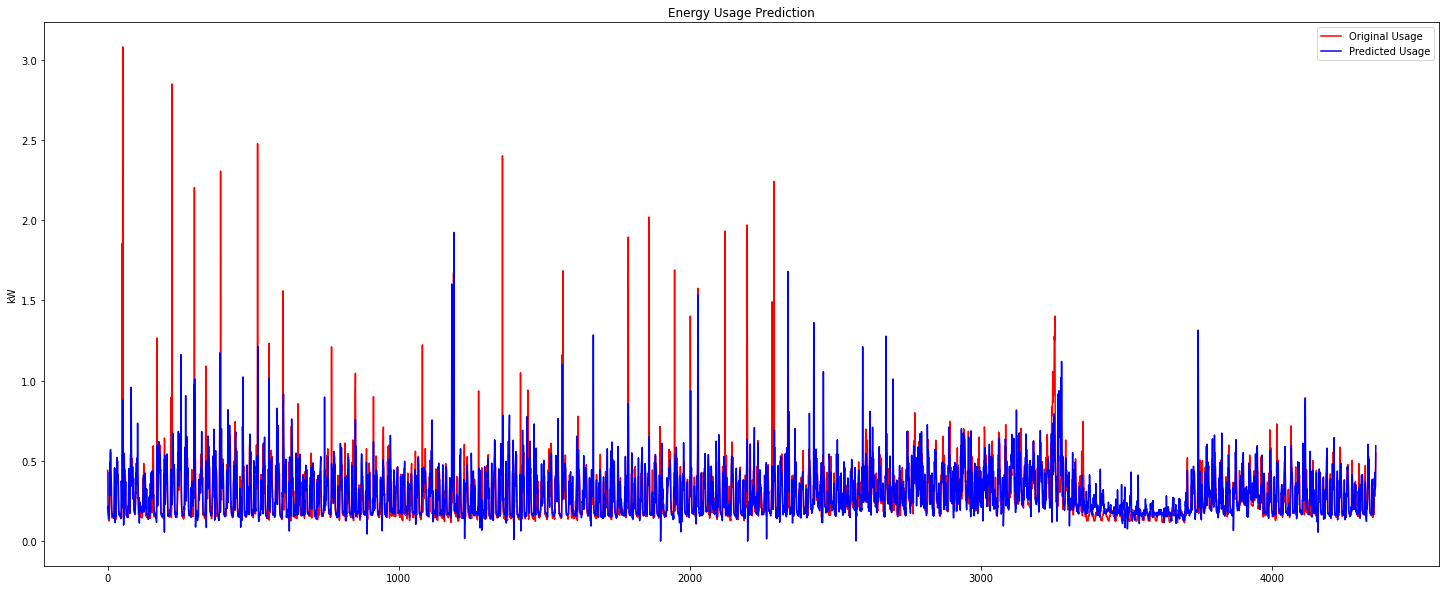

Mean Absolute Percentage Error:  0.2696561999542845
Mean Absolute Error:  0.08263371466048056
Max Absolute Error:  [2.6232479]
Mean Squared Error:  0.029265515442348324
------------------SPECIFIC MODEL------------------


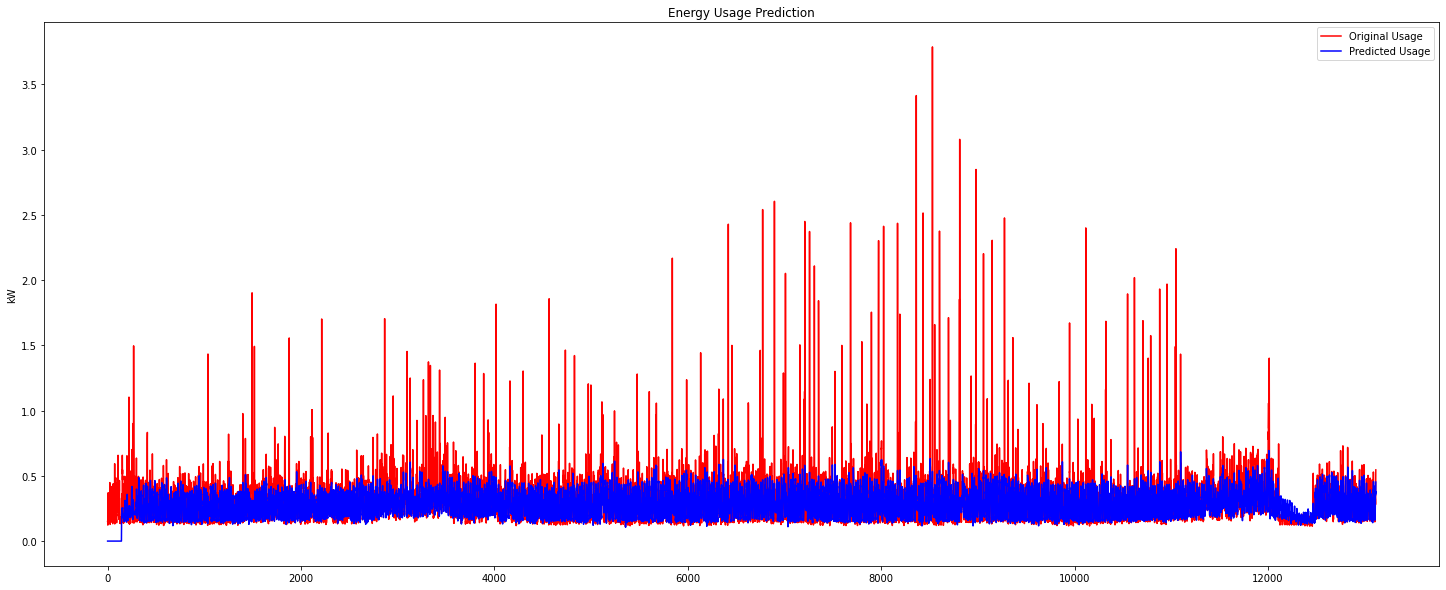

Mean Absolute Percentage Error:  0.22081023403405997
Mean Absolute Error:  0.07048282146824963
Max Absolute Error:  3.254212696010091
Mean Squared Error:  0.02459161633642888
---After 1 year---


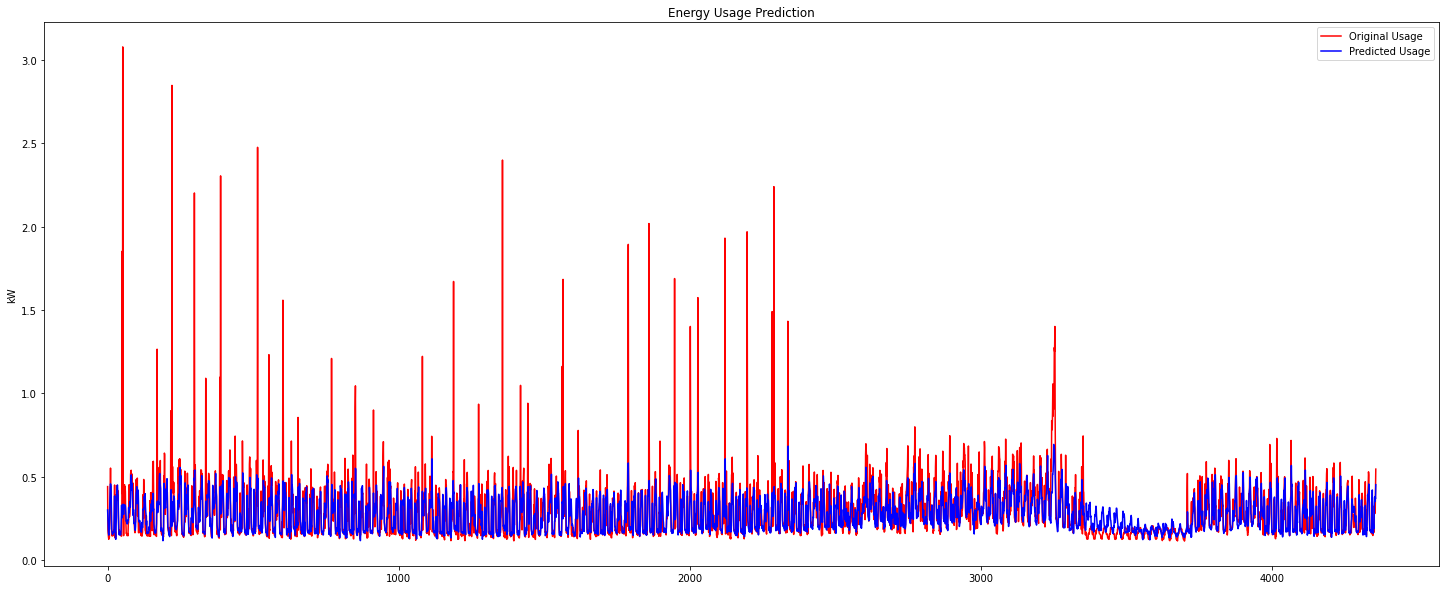

Mean Absolute Percentage Error:  0.20644126703154975
Mean Absolute Error:  0.06476718340621448
Max Absolute Error:  2.8033968663336575
Mean Squared Error:  0.022072599666409023
------------------BEST MODEL------------------


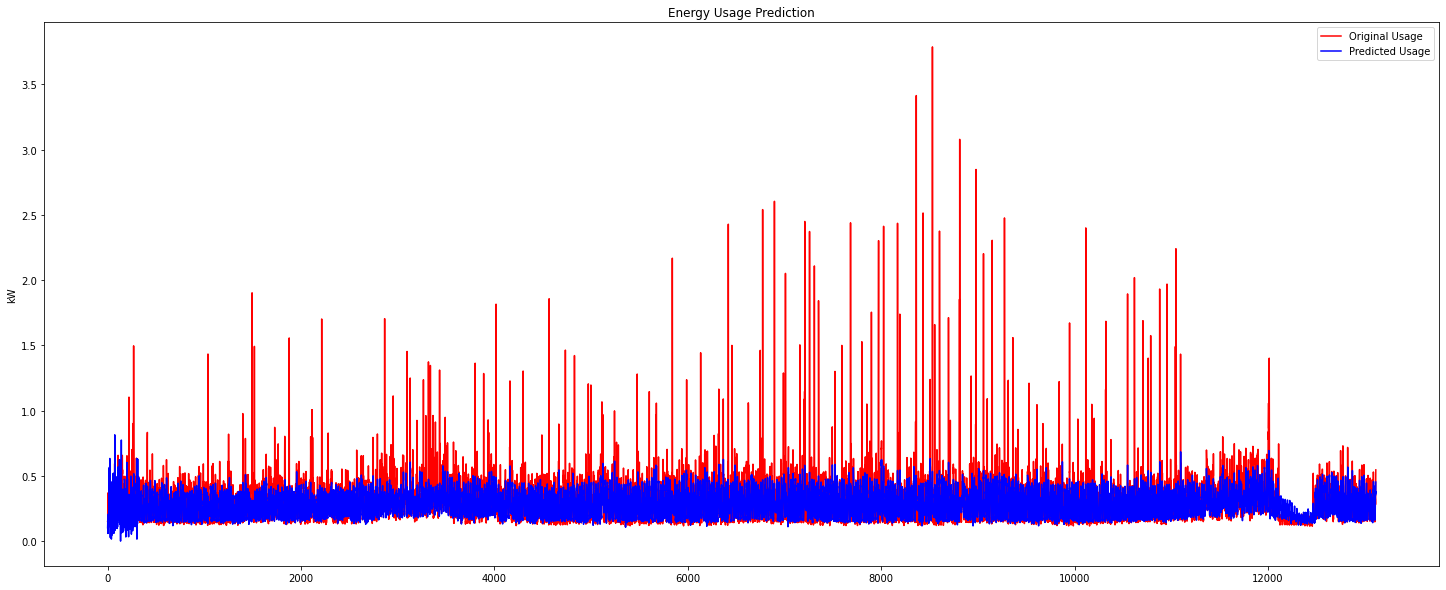

Mean Absolute Percentage Error:  0.21720786140912088
Mean Absolute Error:  0.06930327155980771
Max Absolute Error:  3.254212696010091
Mean Squared Error:  0.024120061877416984


In [16]:
for filename in testHouses:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    best_model = "generic"
    best_preds = []
    
    true = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        df = df.iloc[:13140]

        
    specific_x_scaler = StandardScaler()
    specific_y_scaler = StandardScaler()
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
        
    hourIndex = 0
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        if len(userKnownDf) > 24*365:
            userKnownDf = userKnownDf.iloc[1:]
        
        #needs 24h of prior data
        if hourIndex >= 25:
            #generic Model
            x_test = x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)

            generic_prediction = y_scaler.inverse_transform(generic_Model.predict(test_generator))[0]
            generic_prediction = generic_prediction if generic_prediction >= 0 else 0
            generic_preds.append(generic_prediction)


            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"] if row["use"] != 0 else 0.01
            true.append(actualValue)

            if specific_Model is not None:

                #PREDICT NEXT
                #Specific Model
                #get last past_Window+1 values, the last value will get ignored by time series generator
                x_test = specific_x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
                test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
                x_test = [arr[0].flatten() for arr in test_generator]

                specific_prediction = specific_y_scaler.inverse_transform(specific_Model.predict(x_test))[0]
                specific_prediction = specific_prediction if specific_prediction >= 0 else 0
                specific_preds.append(specific_prediction)

            if best_model == "generic":
                best_preds.append(generic_prediction)
                #if last week accuracy of specific was better
                if specific_Model is not None:
                    if len(specific_preds) >= 24*7:
                        if predict_evaluate(specific_preds[-(7*24):], true[-(7*24):]) < predict_evaluate(generic_preds[-(7*24):], true[-(7*24):]):
                            best_model = "specific"
            else:
                best_preds.append(specific_prediction)
          
        
        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            x_train = specific_x_scaler.fit_transform(userKnownDf[featuresNames].values)
            y_train = specific_y_scaler.fit_transform(userKnownDf[targetName].values.reshape(-1,1))
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=1)
            
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
            
            #------------------------------
            x_train = x_scaler.transform(userKnownDf[featuresNames].values)
            y_train = y_scaler.transform(userKnownDf[targetName].values.reshape(-1,1))

            #Time series
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=64)
            train(generic_Model, train_generator)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("------------------GENERIC MODEL------------------")
    a = predict_evaluate(generic_preds, true, showplots=True)
    print("---After 1 year---")
    a = predict_evaluate(generic_preds[365*24:], true[365*24:], showplots=True)
    

    print("------------------SPECIFIC MODEL------------------")
    specific_preds = [0 for i in range(len(true) - len(specific_preds))] + specific_preds
    a = predict_evaluate(specific_preds, true, showplots=True)
    print("---After 1 year---")
    a = predict_evaluate(specific_preds[365*24:], true[365*24:], showplots=True)
    
    
    print("------------------BEST MODEL------------------")
    a = predict_evaluate(best_preds, true, showplots=True)
            

GENERIC--------


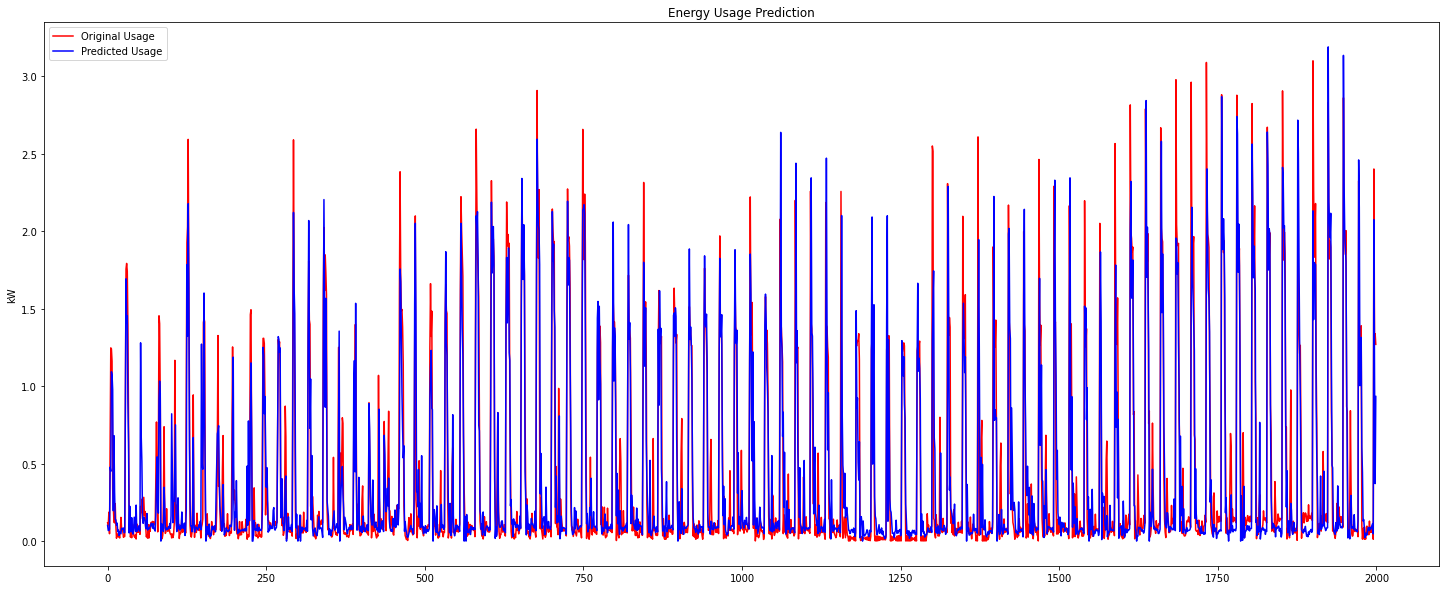

Mean Absolute Percentage Error:  2.948614708023803
Mean Absolute Error:  0.1512656072890319
Max Absolute Error:  [1.5972537]
Mean Squared Error:  0.07360155386514522
SPECIFIC--------


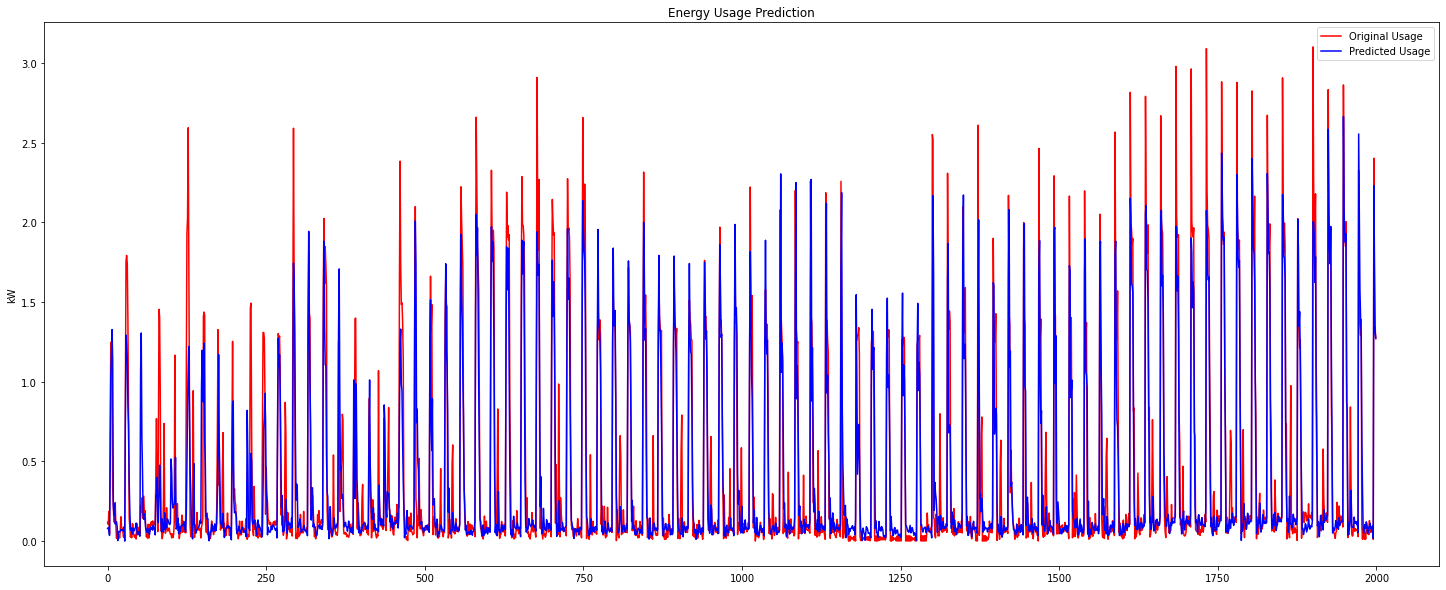

Mean Absolute Percentage Error:  2.4339011868566662
Mean Absolute Error:  0.1377238051663992
Max Absolute Error:  1.5265344268137828
Mean Squared Error:  0.06406233761782719


In [18]:
print("GENERIC--------")


## Test generic model for 1 house

In [ ]:
for filename in testHouses:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_test = x_scaler.transform(features)
    y_test = y_scaler.transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = generic_Model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)